## Bibliotecas

In [1]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import linalg
from numpy import linalg as LA
from scipy.fft import fft, fftfreq
import sklearn
from sklearn.decomposition import PCA
from scipy import signal
import os
import glob
from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler


# Caminho da pasta contendo os arquivos .mat
folder_path = 'C:/Users/LeoVO/Downloads/SSVEP/'

## Processamento dos dados

In [2]:
# Localizar todos os arquivos .mat na pasta
mat_files = sorted(glob.glob(os.path.join(folder_path, '*.mat')))

# Lista para armazenar os arrays individuais
ind_list = []

In [3]:
# Carregamento dos arquivos
for i, mat_file in enumerate(mat_files):
    try:
        mat = loadmat(mat_file)
        data = mat['data']  # Acessa a matriz 'data'
        
        # Remove 500ms iniciais e finais (ficando com 1250 amostras)
        data = data[:, 124:1374, :, :]  # shape final: (64, 1250, 40, 6)
        
        ind_list.append(data)
        print(f"[{i+1}/{len(mat_files)}] {os.path.basename(mat_file)} carregado com sucesso.")
    except Exception as e:
        print(f"[{i+1}] Erro ao carregar {mat_file}: {e}")

# Empilhar todos os arrays em um único array 5D
ind_all = np.stack(ind_list, axis=0)  # shape: (N, 64, 1250, 40, 6)


[1/35] S01.mat carregado com sucesso.
[2/35] S02.mat carregado com sucesso.
[3/35] S03.mat carregado com sucesso.
[4/35] S04.mat carregado com sucesso.
[5/35] S05.mat carregado com sucesso.
[6/35] S06.mat carregado com sucesso.
[7/35] S07.mat carregado com sucesso.
[8/35] S08.mat carregado com sucesso.
[9/35] S09.mat carregado com sucesso.
[10/35] S10.mat carregado com sucesso.
[11/35] S11.mat carregado com sucesso.
[12/35] S12.mat carregado com sucesso.
[13/35] S13.mat carregado com sucesso.
[14/35] S14.mat carregado com sucesso.
[15/35] S15.mat carregado com sucesso.
[16/35] S16.mat carregado com sucesso.
[17/35] S17.mat carregado com sucesso.
[18/35] S18.mat carregado com sucesso.
[19/35] S19.mat carregado com sucesso.
[20/35] S20.mat carregado com sucesso.
[21/35] S21.mat carregado com sucesso.
[22/35] S22.mat carregado com sucesso.
[23/35] S23.mat carregado com sucesso.
[24/35] S24.mat carregado com sucesso.
[25/35] S25.mat carregado com sucesso.
[26/35] S26.mat carregado com suce

In [4]:
# --- parâmetros dinâmicos ---
fs = 250
janela = 5
n_freq = 40
n_rep = 6
n_canais = 64
n_amostras = 1250
n_ind = ind_all.shape[0]

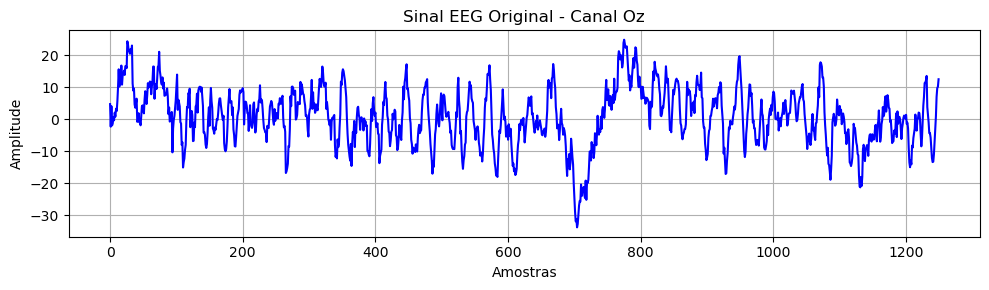

In [5]:
# --- GRÁFICO 1: Sinal original ---
plt.figure(figsize=(10, 3))
plt.plot(ind_all[2, 61, :, 0, 0], label="Sinal EEG Original", color='blue')
plt.title("Sinal EEG Original - Canal Oz")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## Filtro CAR

In [6]:
# --- Filtro CAR ---

ind_all_car = np.zeros_like(ind_all)

for suj in range(n_ind):        # para cada sujeito
    for sti in range(n_freq):    # para cada frequência de estímulo
        for rep in range(n_rep): # para cada repetição

            # Extrai os dados: shape (64 canais, 1250 amostras)
            sinal = ind_all[suj, :, :, sti, rep]

            # Calcula a média entre os canais para cada amostra (shape: (1250,))
            media_canais = np.mean(sinal, axis=0)

            # Aplica o filtro CAR
            sinal_filtrado = sinal - media_canais

            # Armazena no array final
            ind_all_car[suj, :, :, sti, rep] = sinal_filtrado

print(f"Filtro CAR aplicado. Shape final: {ind_all_car.shape}")

Filtro CAR aplicado. Shape final: (35, 64, 1250, 40, 6)


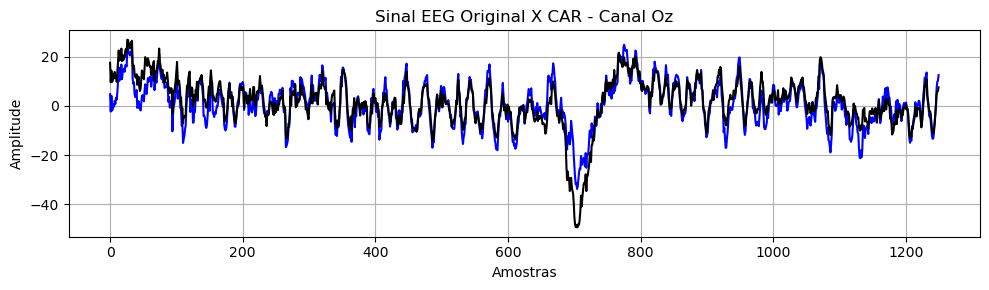

In [7]:
# --- GRÁFICO 2: Sinal após filtro CAR ---
plt.figure(figsize=(10, 3))
plt.plot(ind_all[2, 61, :, 0, 0], label="Sinal EEG Original", color='blue')
plt.plot(ind_all_car[2, 61, :, 0, 0], label="Sinal EEG - Filtro CAR", color='black')
plt.title("Sinal EEG Original X CAR - Canal Oz")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

## Janelamento

In [8]:
# Dados originais
# ind_all_car.shape = (35, 64, 1250, 40, 6)
# Novo shape: (35, 64, 250, 40, 6 * 5) = (35, 64, 250, 40, 30)
ind_car_jan = np.zeros((n_ind, n_canais, fs, n_freq, n_rep * janela))

for subj in range(n_ind):
    for freq in range(n_freq):
        for rep in range(n_rep):
            for j in range(janela):
                ini = j * fs
                fim = ini + fs
                idx_out = rep * janela + j  
                ind_car_jan[subj, :, :, freq, idx_out] = ind_all_car[subj, :, ini:fim, freq, rep]

print(f"Novo shape: {ind_car_jan.shape}")


Novo shape: (35, 64, 250, 40, 30)


## FFT

In [9]:
# FFT ao longo do eixo das 250 amostras
fft_car = np.fft.fft(ind_car_jan, axis=2)

# Frequências correspondentes
freqs = np.fft.fftfreq(250, d=1/fs)

# Pegar apenas as frequências positivas (até Nyquist)
pos_freqs = freqs[:125]

print(f"FFT shape: {fft_car.shape}")


FFT shape: (35, 64, 250, 40, 30)


## Seleção de canais e frequencias 

In [10]:
# Canais selecionados Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2
canais_selecionados = [47, 53, 54, 55, 56, 57, 60, 61, 62]  # pode mudar essa lista

# Array original: (35, 64, 250, 40, 30)
print("Shape original:", fft_car.shape)

# Selecionar os canais desejados
fft_car_9 = fft_car[:, canais_selecionados, :, :, :]

# Novo shape: (35, 9, 250, 40, 30)
print("Novo shape:", fft_car_9.shape)


Shape original: (35, 64, 250, 40, 30)
Novo shape: (35, 9, 250, 40, 30)


In [11]:
# frequencia 8 e 10 Hz
freq_selecionados = [0, 2]  # pode mudar essa lista

# Array original: (35, 9, 250, 40, 30)
print("Shape original:", fft_car_9.shape)

# Selecionar as frequencias desejadas
fft_H = fft_car_9[:, :, :, freq_selecionados, :]

# Novo shape: (35, 9, 250, 2, 30)
print("Novo shape:", fft_H.shape)

Shape original: (35, 9, 250, 40, 30)
Novo shape: (35, 9, 250, 2, 30)


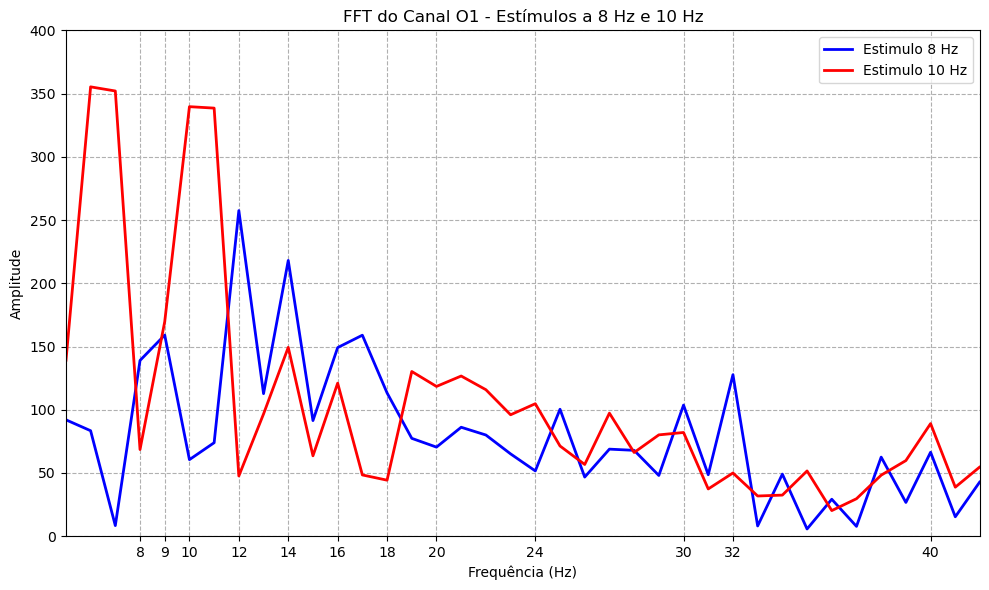

In [12]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(np.abs(fft_H[1,6,:,0,2]), label='Estimulo 8 Hz', color='blue', linewidth=2)
plt.plot(np.abs(fft_H[1,6,:,1,1]), label='Estimulo 10 Hz', color='red', linewidth=2)

# Eixos e escala
plt.xlim([5, 42])
plt.ylim([0, 400])
plt.xticks([8, 9, 10, 12, 14, 16, 18, 20, 24, 30, 32, 40])
plt.grid(True, linestyle='--')

# Títulos e legendas
plt.title('FFT do Canal O1 - Estímulos a 8 Hz e 10 Hz')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

## Matriz H

In [13]:
'''
Parâmetros:
- fft_H: array FFT no formato [n_ind, n_chan, n_freq, n_est, n_rep]
- pos_freqs: vetor com as frequências reais da FFT (positivas)
- n_chan: quantidade de canais (ex: [0,1,2,...])
- n_est: quantidade de estímulos a usar (ex: [0,1,...,7])

Retorna:
- H: matriz de features (n_ind, linhas = n_est x n_rep, colunas = n_chan x len(freqs_estimulo))
'''

n_ind, n_chan, _, n_est, n_rep = fft_H.shape

freqs_estimulo = [8.0, 10.0, 16.0, 20.0, 24.0, 30.0, 32.0, 40.0] # alterar de acordo com a frequencia desejada

H = []
H_por_individuo = []

# O loop mais externo por indivíduo
for ind in range(n_ind):
    matriz_instancias_individuo = []
    # Para cada indivíduo, vamos construir uma lista de linhas
    # Cada linha será uma combinação (estímulo, repetição)
    for est in range(n_est):
        for rep in range(n_rep):
            linha = []
            # Os loops de canal e frequência constroem as colunas de features
            for ch in range(n_chan):
                for f in range(len(freqs_estimulo)):
                    f_target = freqs_estimulo[f]
                    idx_f = np.argmin(np.abs(pos_freqs - f_target))
                    pot = np.abs(fft_H[ind, ch, idx_f, est, rep]) ** 2
                    linha.append(pot)
            # Adiciona a linha de features à matriz de instâncias para o indivíduo atual
            matriz_instancias_individuo.append(linha)
    # Converte a lista de linhas do indivíduo para um array NumPy e adiciona à lista principal        
    H_por_individuo.append(np.array(matriz_instancias_individuo))
# Empilha os arrays de cada indivíduo para formar a matriz H final 3D
H = np.array(H_por_individuo)
print("H shape:", H.shape)

H shape: (35, 60, 72)


## MLP


In [ ]:
n_freq_est = len(freqs_estimulo)

# --- Gerar rótulos numéricos para os estímulos ---
n_ind, n_chan, _, n_est, n_rep = fft_H.shape

y_numeric_por_individuo = []

for ind in range(n_ind): # Loop pelos indivíduos
    rotulos_instancias_individuo = [] # Rótulos para as instâncias deste indivíduo
    for est_idx in range(n_est): # Loop pelos índices dos estímulos
        for rep_idx in range(n_rep): # Loop pelas repetições
            # O rótulo para esta sub-instância é o ID do estímulo
            rotulos_instancias_individuo.append(est_idx)
    y_numeric_por_individuo.append(np.array(rotulos_instancias_individuo))

y_numeric = np.array(y_numeric_por_individuo)

y_numeric_flat = y_numeric.flatten()

y_numeric_reshaped = y_numeric_flat.reshape(-1, 1)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar e transformar os rótulos numéricos
y_one_hot_flat = encoder.fit_transform(y_numeric_reshaped)

print(f"n_classes: {n_est}")
y_one_hot_final = y_one_hot_flat.reshape(n_ind, n_est * n_rep, n_est)

print(f"Shape final da matriz de rótulos one-hot: {y_one_hot_final.shape}")

print("\nEntradas dos rótulos one-hot (para o primeiro indivíduo):")
print(y_one_hot_final[0, 20:40, :])

n_classes: 2
Shape final da matriz de rótulos one-hot: (35, 60, 2)

Etradas dos rótulos one-hot (para o primeiro indivíduo):
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [17]:
# Definir sementes aleatórias para reprodutibilidade
SEED = 42 # Um número inteiro arbitrário
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Função para construir o modelo MLP

def build_mlp_cenario1(input_dim, n_classes, hidden_layers=[64,32], activation='tanh', optimizer='adam', learning_rate=0.0001, final_activation='softmax', **kwargs):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(hidden_layers[0], activation=activation))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
    model.add(Dense(n_classes, activation=final_activation))
     # Criar o otimizador com a taxa de aprendizado
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Função para construir o modelo MLP

def build_mlp(input_dim, n_classes, hidden_layers=[150, 70, 35], activation='tanh', optimizer='adam', learning_rate=0.0005, final_activation='softmax', **kwargs):
    model = Sequential()
    model.add(InputLayer(shape=(input_dim,)))
    model.add(Dense(hidden_layers[0], activation=activation))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
    model.add(Dense(n_classes, activation=final_activation))
     # Criar o otimizador com a taxa de aprendizado
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model


# Normalização por sujeito
H_normalized = np.zeros_like(H)

for subj in range(n_ind):
    scaler = StandardScaler()
    H_normalized[subj] = scaler.fit_transform(H[subj])

### Gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier 

model_wrapper = KerasClassifier(
    model=build_mlp, 
    input_dim = H.shape[2], 
    n_classes=n_est,  
    verbose=0
)

param_grid = {
    'model__hidden_layers_config': [[100, 50], [150, 70, 35], [64, 32, 16], [150]],
    'model__activation': ['relu', 'tanh'], 
    'model__final_activation': ['softmax'], 
    'model__optimizer_name': ['adam'], 
    'model__learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [8, 16, 32, 64], 
    'epochs': [20, 50, 100], 
}

grid_search = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=2 
)

all_X_train_data = []
all_y_train_data = []

for subj in range(H.shape[0]):
    X_subj = H[subj]
    y_subj = y_one_hot_final[subj]

    X_train_current_subj = np.concatenate([X_subj[:24], X_subj[30:54]], axis=0)
    y_train_current_subj = np.concatenate([y_subj[:24], y_subj[30:54]], axis=0)

    all_X_train_data.append(X_train_current_subj)
    all_y_train_data.append(y_train_current_subj)

X_train_combined = np.concatenate(all_X_train_data, axis=0)
y_train_combined = np.concatenate(all_y_train_data, axis=0)


print("Iniciando Grid Search...")
grid_search.fit(X_train_combined, y_train_combined)
print("Grid Search Concluído.")

# Obtenha os melhores parâmetros
best_params = grid_search.best_params_
print(f"Melhor pontuação (acurácia): {grid_search.best_score_:.4f}")
print(f"Melhores parâmetros encontrados: {best_params}")

# Extraia os melhores hiperparâmetros para usar no seu loop individual
best_hidden_layers = best_params['model__hidden_layers_config']
best_activation = best_params['model__activation']
best_final_activation = best_params['model__final_activation']
best_optimizer_name = best_params['model__optimizer_name']
best_learning_rate = best_params['model__learning_rate']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs'] # Note: epochs aqui é o epochs do GridSearch,
                                     # use um valor alto para o EarlyStopping

Iniciando Grid Search...
Fitting 3 folds for each of 288 candidates, totalling 864 fits


c:\Users\LeoVO\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\LeoVO\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Grid Search Concluído.
Melhor pontuação (acurácia): 0.9018
Melhores parâmetros encontrados: {'batch_size': 64, 'epochs': 100, 'model__activation': 'tanh', 'model__final_activation': 'softmax', 'model__hidden_layers_config': [150, 70, 35], 'model__learning_rate': 0.0005, 'model__optimizer_name': 'adam'}


### MLP - Teste individual

In [19]:
# Dimensões de H
n_subjects, n_samples, n_features = H.shape
n_classes = n_est

# Teste individual
all_y_true = []
all_y_pred = []
accuracies = []
histories = [] 


for subj in range(n_subjects):
        
    tf.keras.backend.clear_session()
    
    X = H_normalized[subj]
    y_subj = y_one_hot_final[subj]
        
    # Divisão: 24 para treino, 6 para teste (por estímulo, totalizando 48 treino + 12 teste)
    X_train = np.concatenate([X[:24], X[30:54]], axis=0)   
    y_train = np.concatenate([y_subj[:24], y_subj[30:54]], axis=0)

    X_test = np.concatenate([X[24:30], X[54:]], axis=0)    
    y_test = np.concatenate([y_subj[24:30], y_subj[54:]], axis=0)

    # Modelo MLP    
    model = build_mlp_cenario1(
        input_dim=n_features,
        n_classes=n_classes,
        #hidden_layers_config=best_hidden_layers,
        #activation=best_activation,
        #final_activation=best_final_activation,
        #optimizer_name=best_optimizer_name,
        #learning_rate=best_learning_rate
   )

    # Inclua EarlyStopping para evitar overfitting no treinamento individual
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs=100,
        #epochs=best_epochs,
        batch_size=8, 
        #batch_size=best_batch_size,
        verbose=0,
        validation_split=0.2,
        #callbacks=[early_stopping_callback]
    )

    # Salva o histórico
    histories.append(history.history)
        
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)
        
    acc = accuracy_score(y_true_labels, y_pred_labels)
    accuracies.append(acc)
    print(f"[Indivíduo {subj+1:02d}] Acurácia: {acc:.2%}")

    # Armazenar para métricas finais
    all_y_true.extend(y_true_labels)
    all_y_pred.extend(y_pred_labels)

# Resultado final
print(f"\nAcurácia média: {np.mean(accuracies):.2%} ± {np.std(accuracies):.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[Indivíduo 01] Acurácia: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
[Indivíduo 02] Acurácia: 83.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
[Indivíduo 03] Acurácia: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[Indivíduo 04] Acurácia: 91.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[Indivíduo 05] Acurácia: 83.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[Indivíduo 06] Acurácia: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[Indivíduo 07] Acurácia: 58.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[Indivíduo 08] Acurácia: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[Indivíduo 09] Acurácia: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
[Indivíduo 10] Acurácia: 75.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
[Indivíduo 11] Acurácia: 58.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
[Indivíduo 12] Acurácia: 91.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[Indivíduo 13] Acurácia: 83.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[Indivíduo 14] Acurácia: 91.67%
1/1 ━━━━━━━━━━━

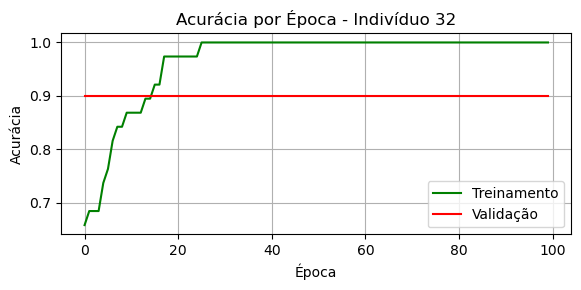

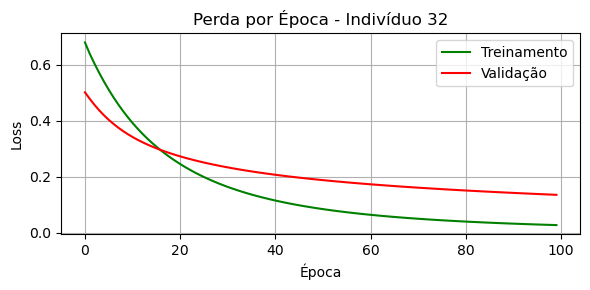

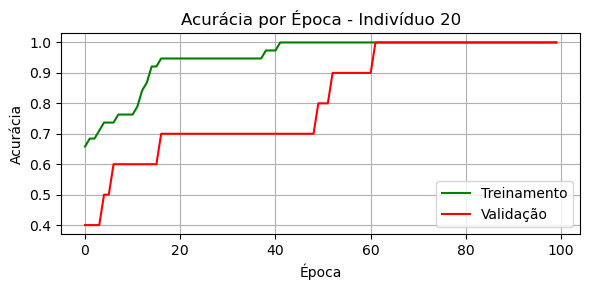

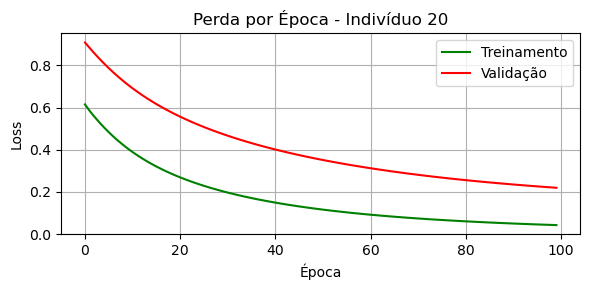

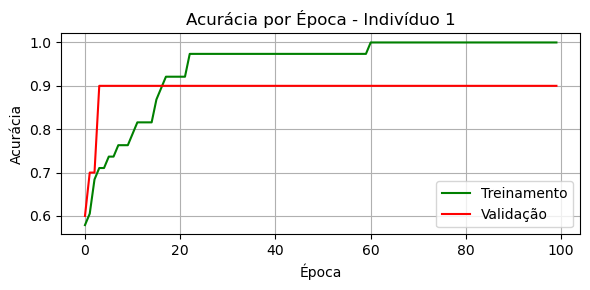

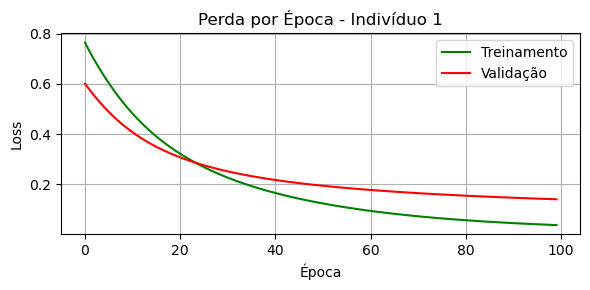

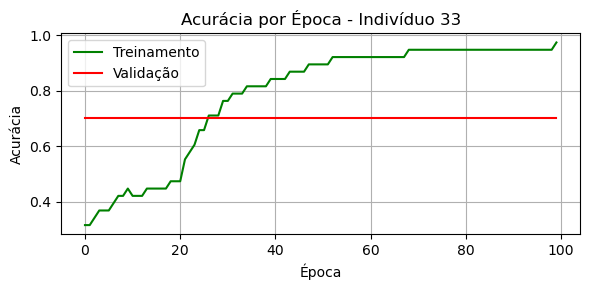

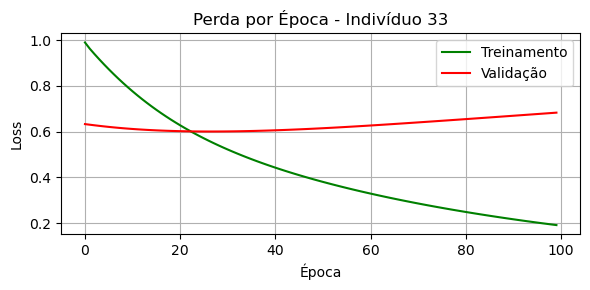

In [20]:
# Análise dos indivíduos com melhor e pior desempenho
indices_interesse = list(np.argsort(accuracies)[-3:]) + [np.argmin(accuracies)]

for idx in indices_interesse:
    hist = histories[idx]

    # Acurácia
    plt.figure(figsize=(6, 3))
    plt.plot(hist['categorical_accuracy'], label='Treinamento', color='green')
    plt.plot(hist.get('val_categorical_accuracy', []), label='Validação', color='red')
    plt.title(f'Acurácia por Época - Indivíduo {idx+1}')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Perda
    plt.figure(figsize=(6, 3))
    plt.plot(hist['loss'], label='Treinamento', color='green')
    plt.plot(hist.get('val_loss', []), label='Validação', color='red')
    plt.title(f'Perda por Época - Indivíduo {idx+1}')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



Relatório de Classificação Geral:
              precision    recall  f1-score   support

           0     0.8455    0.8857    0.8651       210
           1     0.8800    0.8381    0.8585       210

    accuracy                         0.8619       420
   macro avg     0.8627    0.8619    0.8618       420
weighted avg     0.8627    0.8619    0.8618       420



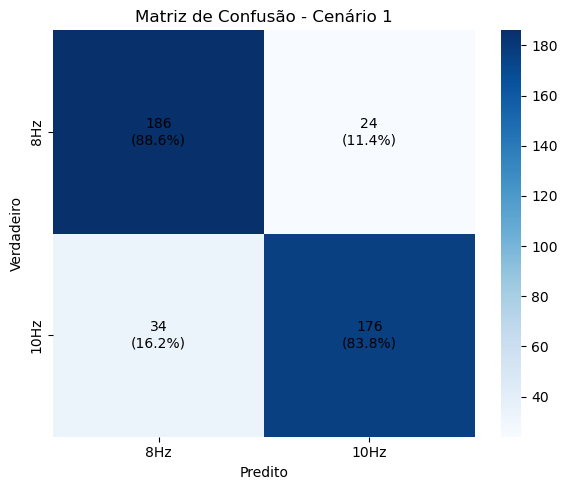

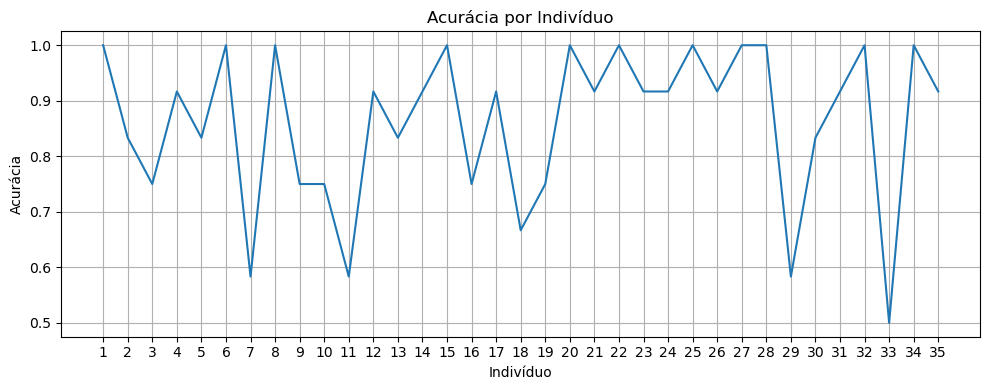

In [22]:
# Métricas finais globais
print("\nRelatório de Classificação Geral:")
print(classification_report(all_y_true, all_y_pred, digits=4))

# Matriz de confusão absoluta
cm = confusion_matrix(all_y_true, all_y_pred)
# Matriz normalizada (por linha - recall)
cm_percent = confusion_matrix(all_y_true, all_y_pred, normalize='true') * 100
# Plot com seaborn
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True,
                 xticklabels=['8Hz', '10Hz'],
                 yticklabels=['8Hz', '10Hz'])
# Adiciona valores absolutos + porcentagem
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        abs_val = cm[i, j]
        pct_val = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5,
                f'{abs_val}\n({pct_val:.1f}%)',
                ha='center', va='center', color='black', fontsize=10)
plt.title("Matriz de Confusão - Cenário 1")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

# Gráfico de acurácia por indivíduo
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(accuracies)+1), accuracies)  
plt.xticks(range(1, len(accuracies)+1))  
plt.title("Acurácia por Indivíduo")
plt.xlabel("Indivíduo")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.show()


### MLP- 34X1


In [50]:
n_instances_per_subject = H.shape[0] * H.shape[2] 
loso_accuracies = []
loso_classification_reports = []
all_loso_y_true = []
all_loso_y_pred = []

for test_subj_idx in range(n_subjects):
    tf.keras.backend.clear_session() # Limpa a sessão para cada fold LOSO

    # Dados de teste para o sujeito atual
    X_loso_test = H_normalized[test_subj_idx]
    y_loso_test = y_one_hot_final[test_subj_idx]

    # Dados de treino para os outros sujeitos
    train_subj_indices = [i for i in range(n_subjects) if i != test_subj_idx]

    X_loso_train_list = []
    y_loso_train_list = []
    for train_idx in train_subj_indices:
        X_loso_train_list.append(H_normalized[train_idx])
        y_loso_train_list.append(y_one_hot_final[train_idx])

    X_loso_train = np.concatenate(X_loso_train_list, axis=0)
    y_loso_train = np.concatenate(y_loso_train_list, axis=0)

    print(f" Teste: Indivíduo {test_subj_idx+1}")

    # Crie o modelo com os melhores parâmetros globais encontrados pelo Grid Search
    model_loso = build_mlp(
        input_dim=H.shape[2], 
        n_classes=n_est,
        #hidden_layers_config=best_hidden_layers,
        #activation=best_activation,
        #final_activation=best_final_activation,
        #optimizer_name=best_optimizer_name,
        #learning_rate=best_learning_rate
    )

    # Use EarlyStopping para o treinamento LOSO
    early_stopping_callback_loso = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history_loso = model_loso.fit(
        X_loso_train, y_loso_train,
        #epochs=best_epochs,
        epochs=100,
        #batch_size=best_batch_size,
        batch_size=64,
        verbose=0, 
        validation_split=0.1, 
        #callbacks=[early_stopping_callback_loso]
    )

    # Avalie o modelo no sujeito de teste deixado de fora
    y_loso_pred = model_loso.predict(X_loso_test)
    y_loso_pred_labels = np.argmax(y_loso_pred, axis=1)
    y_loso_true_labels = np.argmax(y_loso_test, axis=1)

    acc_loso = accuracy_score(y_loso_true_labels, y_loso_pred_labels)
    loso_accuracies.append(acc_loso)
    print(f"  Acurácia LOSO para Indivíduo {test_subj_idx+1}: {acc_loso:.2%}")

    # Armazene para o relatório geral LOSO
    all_loso_y_true.extend(y_loso_true_labels)
    all_loso_y_pred.extend(y_loso_pred_labels)

# Resultados finais LOSO
print(f"\n--- Resultados Finais LOSO ---")
print(f"Acurácia Média LOSO: {np.mean(loso_accuracies):.2%} ± {np.std(loso_accuracies):.2%}")


 Teste: Indivíduo 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
  Acurácia LOSO para Indivíduo 1: 93.33%
 Teste: Indivíduo 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
  Acurácia LOSO para Indivíduo 2: 85.00%
 Teste: Indivíduo 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  Acurácia LOSO para Indivíduo 3: 90.00%
 Teste: Indivíduo 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
  Acurácia LOSO para Indivíduo 4: 83.33%
 Teste: Indivíduo 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
  Acurácia LOSO para Indivíduo 5: 91.67%
 Teste: Indivíduo 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
  Acurácia LOSO para Indivíduo 6: 93.33%
 Teste: Indivíduo 7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
  Acurácia LOSO para Indivíduo 7: 86.67%
 Teste: Indivíduo 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
  Acurácia LOSO para Indivíduo 8: 96.67%
 Teste: Indivíduo 9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
  Acurácia LOSO para Indivíduo 9: 93.33%
 Teste: Indivíduo 10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
  Acurácia LOSO para Indivíduo 10: 90.00%
 Teste: 


Relatório de Classificação LOSO Geral:
              precision    recall  f1-score   support

           0     0.8900    0.8857    0.8878      1050
           1     0.8863    0.8905    0.8884      1050

    accuracy                         0.8881      2100
   macro avg     0.8881    0.8881    0.8881      2100
weighted avg     0.8881    0.8881    0.8881      2100



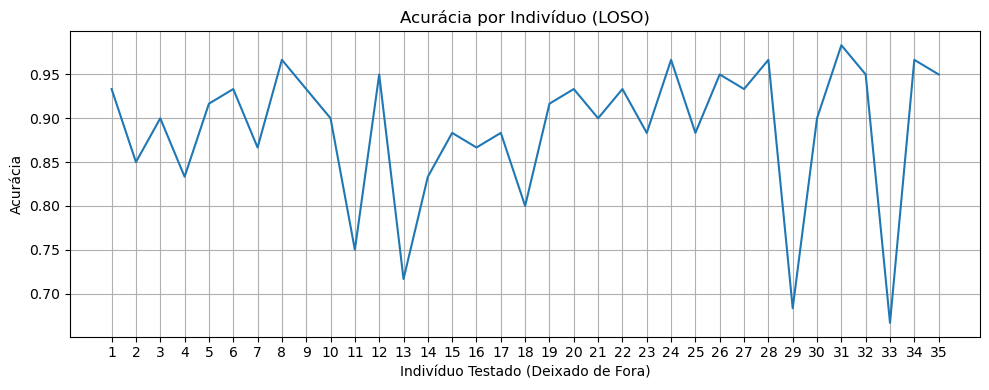

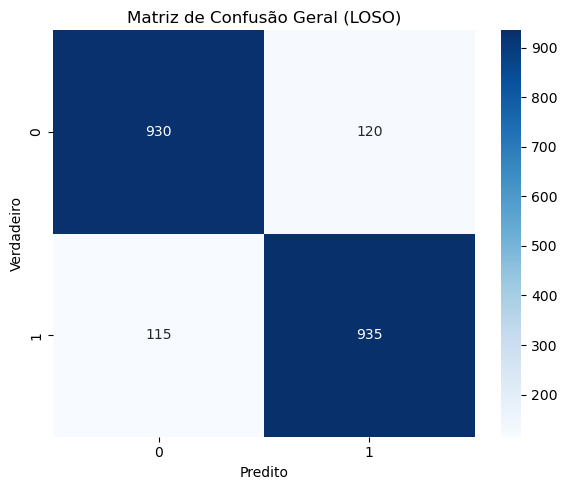

In [ ]:
print("\nRelatório de Classificação LOSO Geral:")
print(classification_report(all_loso_y_true, all_loso_y_pred, digits=4))

# Gráfico de acurácia por indivíduo LOSO
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(loso_accuracies)+1), loso_accuracies)
plt.xticks(range(1, len(loso_accuracies)+1))
plt.title("Acurácia por Indivíduo (LOSO)")
plt.xlabel("Indivíduo Testado (Deixado de Fora)")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de confusão absoluta
cm = confusion_matrix(all_loso_y_true, all_loso_y_pred)

# Matriz normalizada (por linha - recall)
cm_percent = confusion_matrix(all_loso_y_true, all_loso_y_pred, normalize='true') * 100

# Plot com seaborn
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True,
                 xticklabels=['8Hz', '10Hz'],
                 yticklabels=['8Hz', '10Hz'])

# Adiciona valores absolutos + porcentagem
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        abs_val = cm[i, j]
        pct_val = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5,
                f'{abs_val}\n({pct_val:.1f}%)',
                ha='center', va='center', color='black', fontsize=10)

plt.title("Matriz de Confusão - Cenário 2")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()

### MLP - 34-N x 1

In [23]:
# --- índices dos piores indivíduos (baseado em 0-index) ---
# Usando os resultados do seu primeiro teste individual:
# Indivíduo 7 (idx 6)
# Indivíduo 11 (idx 10)
# Indivíduo 17 (idx 16)
# Indivíduo 18 (idx 17)
# Indivíduo 29 (idx 28)
# Indivíduo 33 (idx 32)

worst_subj_indices_0indexed = [6, 10, 16, 17, 28, 32] 
worst_subj_ids_1based = [idx + 1 for idx in worst_subj_indices_0indexed] 

print(f"Indivíduos a serem excluídos da avaliação LOSO (base 1): {worst_subj_ids_1based}")

# --- Preparar os dados para a avaliação LOSO sem os piores indivíduos ---
# Crie uma lista de índices de sujeitos que serão incluídos
included_subj_indices = [i for i in range(H.shape[0]) if i not in worst_subj_indices_0indexed]
print(f"Número de indivíduos restantes para a avaliação LOSO: {len(included_subj_indices)}")

Indivíduos a serem excluídos da avaliação LOSO (base 1): [7, 11, 17, 18, 29, 33]
Número de indivíduos restantes para a avaliação LOSO: 29


In [24]:
loso_accuracies_filtered = []
all_loso_y_true_filtered = []
all_loso_y_pred_filtered = []

for test_subj_idx in included_subj_indices:
    tf.keras.backend.clear_session() 

    X_loso_test = H_normalized[test_subj_idx]
    y_loso_test = y_one_hot_final[test_subj_idx]

    train_subj_indices = [i for i in included_subj_indices if i != test_subj_idx]

    X_loso_train_list = []
    y_loso_train_list = []
    for train_idx in train_subj_indices:
        X_loso_train_list.append(H_normalized[train_idx])
        y_loso_train_list.append(y_one_hot_final[train_idx])

    X_loso_train = np.concatenate(X_loso_train_list, axis=0)
    y_loso_train = np.concatenate(y_loso_train_list, axis=0)

    print(f"  LOSO Teste: Indivíduo {test_subj_idx+1}")

    # Crie o modelo com os melhores parâmetros globais (anteriormente encontrados)
    model_loso = build_mlp(
        input_dim=n_features,
        n_classes=n_est,
        #hidden_layers_config=best_hidden_layers,
        #activation=best_activation,
        #final_activation=best_final_activation,
        #optimizer_name=best_optimizer_name,
        #learning_rate=best_learning_rate
    )

    # Use EarlyStopping para o treinamento LOSO
    early_stopping_callback_loso = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )

    history_loso = model_loso.fit(
        X_loso_train, y_loso_train,
        epochs = 100,
        #epochs=best_epochs,
        batch_size=64,
        #batch_size=best_batch_size,
        verbose=0, 
        validation_split=0.1, 
        #callbacks=[early_stopping_callback_loso]
    )

    # Avalie o modelo no sujeito de teste deixado de fora
    y_loso_pred = model_loso.predict(X_loso_test)
    y_loso_pred_labels = np.argmax(y_loso_pred, axis=1)
    y_loso_true_labels = np.argmax(y_loso_test, axis=1)

    acc_loso = accuracy_score(y_loso_true_labels, y_loso_pred_labels)
    loso_accuracies_filtered.append(acc_loso)
    print(f"  Acurácia LOSO para Indivíduo {test_subj_idx+1}: {acc_loso:.2%}")

    # Armazene para o relatório geral LOSO
    all_loso_y_true_filtered.extend(y_loso_true_labels)
    all_loso_y_pred_filtered.extend(y_loso_pred_labels)

# --- Resultados Finais LOSO (Filtrado) ---
print(f"\n--- Resultados Finais LOSO (Excluindo Indivíduos {worst_subj_ids_1based}) ---")
print(f"Acurácia Média LOSO (Filtrado): {np.mean(loso_accuracies_filtered):.2%} ± {np.std(loso_accuracies_filtered):.2%}")

  LOSO Teste: Indivíduo 1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
  Acurácia LOSO para Indivíduo 1: 96.67%
  LOSO Teste: Indivíduo 2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
  Acurácia LOSO para Indivíduo 2: 80.00%
  LOSO Teste: Indivíduo 3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
  Acurácia LOSO para Indivíduo 3: 91.67%
  LOSO Teste: Indivíduo 4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
  Acurácia LOSO para Indivíduo 4: 90.00%
  LOSO Teste: Indivíduo 5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
  Acurácia LOSO para Indivíduo 5: 96.67%
  LOSO Teste: Indivíduo 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
  Acurácia LOSO para Indivíduo 6: 95.00%
  LOSO Teste: Indivíduo 8
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
  Acurácia LOSO para Indivíduo 8: 98.33%
  LOSO Teste: Indivíduo 9
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
  Acurácia LOSO para Indivíduo 9: 95.00%
  LOSO Teste: Indivíduo 10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
  Acurácia LOSO para Indivíduo 10: 91.67%
  LOSO Teste: Indivíduo 12
2/2 ━━━━━━━━━━━━━━━━━━━━ 


Relatório de Classificação LOSO Geral (Filtrado):
              precision    recall  f1-score   support

           0     0.9211    0.9253    0.9232       870
           1     0.9249    0.9207    0.9228       870

    accuracy                         0.9230      1740
   macro avg     0.9230    0.9230    0.9230      1740
weighted avg     0.9230    0.9230    0.9230      1740



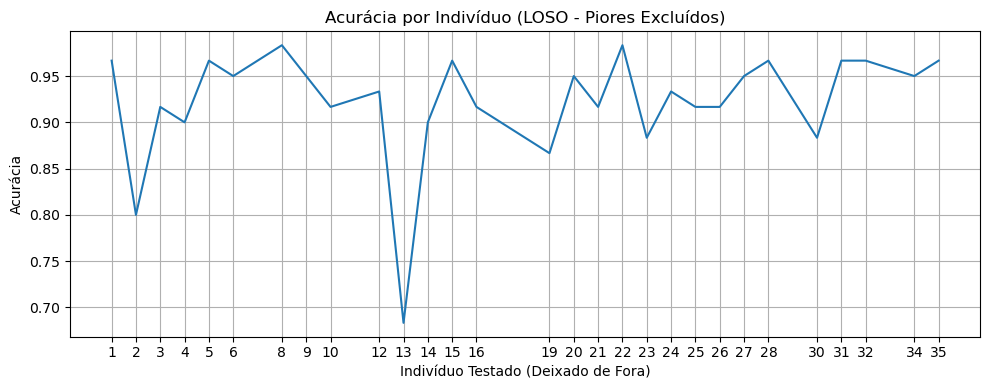

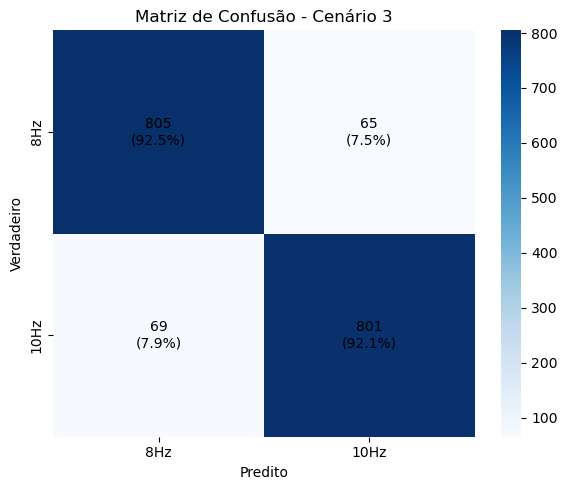

In [25]:
print("\nRelatório de Classificação LOSO Geral (Filtrado):")
print(classification_report(all_loso_y_true_filtered, all_loso_y_pred_filtered, digits=4))

# --- Plotting e Matriz de Confusão para LOSO Filtrado ---
# Gráfico de acurácia por indivíduo LOSO (Filtrado)
plt.figure(figsize=(10, 4))
plt.plot([idx + 1 for idx in included_subj_indices], loso_accuracies_filtered) # Usar IDs originais para o eixo X
plt.xticks([idx + 1 for idx in included_subj_indices])
plt.title("Acurácia por Indivíduo (LOSO - Piores Excluídos)")
plt.xlabel("Indivíduo Testado (Deixado de Fora)")
plt.ylabel("Acurácia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de confusão absoluta
cm = confusion_matrix(all_loso_y_true_filtered, all_loso_y_pred_filtered)

# Matriz normalizada (por linha - recall)
cm_percent = confusion_matrix(all_loso_y_true_filtered, all_loso_y_pred_filtered, normalize='true') * 100

# Plot com seaborn
plt.figure(figsize=(6,5))
ax = sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True,
                 xticklabels=['8Hz', '10Hz'],
                 yticklabels=['8Hz', '10Hz'])

# Adiciona valores absolutos + porcentagem
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        abs_val = cm[i, j]
        pct_val = cm_percent[i, j]
        ax.text(j + 0.5, i + 0.5,
                f'{abs_val}\n({pct_val:.1f}%)',
                ha='center', va='center', fontsize=10)

plt.title("Matriz de Confusão - Cenário 3")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.tight_layout()
plt.show()


--- Avaliação dos Indivíduos Excluídos ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Indivíduo 7 - Acurácia: 86.67%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Indivíduo 11 - Acurácia: 75.00%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Indivíduo 17 - Acurácia: 90.00%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Indivíduo 18 - Acurácia: 81.67%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Indivíduo 29 - Acurácia: 68.33%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Indivíduo 33 - Acurácia: 61.67%

Acurácia Média dos Excluídos: 77.22% ± 9.98%


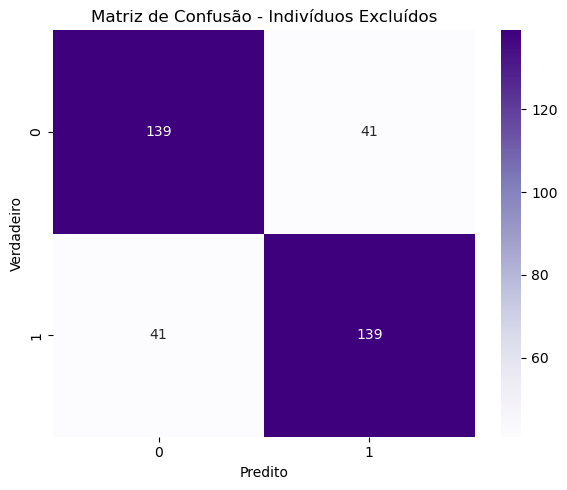

In [ ]:
# Avaliação dos 6 indivíduos excluídos usando o modelo treinado com os demais
print("\n--- Avaliação dos Indivíduos Excluídos ---")
w_excluded_acc = []
all_y_true_excluded = []
all_y_pred_excluded = []

X_train_excluded = np.concatenate([H_normalized[i] for i in included_subj_indices], axis=0)
y_train_excluded = np.concatenate([y_one_hot_final[i] for i in included_subj_indices], axis=0)

model_excluded = build_mlp(
    input_dim=n_features,
    n_classes=n_est,
)
model_excluded.fit(
    X_train_excluded, y_train_excluded,
    epochs=100,
    batch_size=64,
    verbose=0,
    validation_split=0.1
)

for excl_idx in worst_subj_indices_0indexed:
    X_excl_test = H_normalized[excl_idx]
    y_excl_test = y_one_hot_final[excl_idx]

    y_pred_excl = model_excluded.predict(X_excl_test)
    y_pred_labels = np.argmax(y_pred_excl, axis=1)
    y_true_labels = np.argmax(y_excl_test, axis=1)

    acc_excl = accuracy_score(y_true_labels, y_pred_labels)
    print(f"Indivíduo {excl_idx+1} - Acurácia: {acc_excl:.2%}")

    w_excluded_acc.append(acc_excl)
    all_y_true_excluded.extend(y_true_labels)
    all_y_pred_excluded.extend(y_pred_labels)

print(f"\nAcurácia Média dos Excluídos: {np.mean(w_excluded_acc):.2%} ± {np.std(w_excluded_acc):.2%}")

cm_excluded = confusion_matrix(all_y_true_excluded, all_y_pred_excluded)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_excluded, annot=True, fmt='d', cmap='Purples', xticklabels=range(n_est), yticklabels=range(n_est))
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão - Indivíduos Excluídos")
plt.tight_layout()
plt.show()